In [27]:
import pandas as pd
import numpy as np
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import LSTM, Input, Embedding, Dense
from tensorflow.keras.models import Model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from datasets import DatasetDict, Dataset

In [28]:
def load_data(word2vec = True):
  data = pd.read_csv("spam_ham_dataset.csv")
  data = data.drop(["Unnamed: 0"], axis=1)
  if word2vec:
    data['text_clean'] = data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
    texts = data["text_clean"]
  else:
    texts = data["text"]
  labels = data["label_num"]
  print(data.shape)
  return data, texts, labels

In [30]:
data, texts, labels = load_data()

(5171, 4)


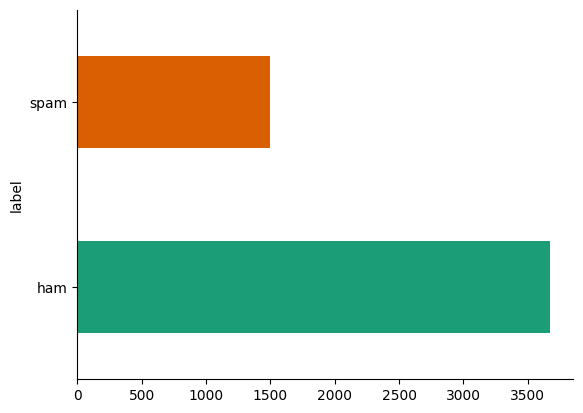

In [31]:
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Word2Vec with Linear Regression

In [34]:
model = gensim.models.Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

# Average word vectors for each document
def document_vector(doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

X = np.array([document_vector(doc) for doc in texts])
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(4136, 100)
(1035, 100)


In [35]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f'Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

Accuracy: 0.9642512077294686 
 Precision: 0.9238410596026491 
 Recall: 0.9522184300341296 
 F1: 0.9378151260504202


RNN

In [37]:
data, texts, labels = load_data(word2vec=False)

(5171, 3)


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=100)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [51]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=100))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
130/130 [==============================] - 34s 239ms/step - loss: 0.4019 - accuracy: 0.8044 - val_loss: 0.1927 - val_accuracy: 0.9208
Epoch 2/5
130/130 [==============================] - 23s 181ms/step - loss: 0.0473 - accuracy: 0.9862 - val_loss: 0.0983 - val_accuracy: 0.9614
Epoch 3/5
130/130 [==============================] - 18s 135ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0796 - val_accuracy: 0.9691
Epoch 4/5
130/130 [==============================] - 17s 134ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.1024 - val_accuracy: 0.9633
Epoch 5/5
130/130 [==============================] - 17s 126ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0889 - val_accuracy: 0.9643


In [52]:
predictions = model.predict(X_test) > 0.5
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f'Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

33/33 [==============================] - 0s 9ms/step
Accuracy: 0.9642512077294686 
 Precision: 0.9324324324324325 
 Recall: 0.9419795221843004 
 F1: 0.937181663837012


Seq2Seq - encoder decoder lstm

In [54]:
encoder_inputs = Input(shape=(100,))
x = Embedding(len(word_index) + 1, 128)(encoder_inputs)
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(100,))
x = Embedding(len(word_index) + 1, 128)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = Dense(1, activation='sigmoid')
outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit([X_train, X_train], y_train, epochs=5, validation_data=([X_test, X_test], y_test))

Epoch 1/5
130/130 [==============================] - 72s 495ms/step - loss: 0.3296 - accuracy: 0.8636 - val_loss: 0.3364 - val_accuracy: 0.8784
Epoch 2/5
130/130 [==============================] - 55s 424ms/step - loss: 0.1304 - accuracy: 0.9667 - val_loss: 0.1691 - val_accuracy: 0.9478
Epoch 3/5
130/130 [==============================] - 49s 378ms/step - loss: 0.0574 - accuracy: 0.9887 - val_loss: 0.1009 - val_accuracy: 0.9786
Epoch 4/5
130/130 [==============================] - 45s 347ms/step - loss: 0.0161 - accuracy: 0.9978 - val_loss: 0.1771 - val_accuracy: 0.9666
Epoch 5/5
130/130 [==============================] - 47s 358ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.2057 - val_accuracy: 0.9702


In [64]:
predictions = [np.max(x) for x in (model.predict([X_test, X_test]) > 0.5)]
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f'Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

33/33 [==============================] - 2s 53ms/step
Accuracy: 0.9729468599033816 
 Precision: 0.9715302491103203 
 Recall: 0.931740614334471 
 F1: 0.9512195121951219
